# (28751) Eggl orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '28751'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)

In [4]:
add_gaia_obs = False
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, de_kernel_path, t_min_tdb=None, t_max_tdb=None, verbose=True)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 0 observations 
	 0 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 521 observations. Debiased 900 observations. No biasing information for 6 observations.
Applied default weight of 1 arcsec to 67 CCD observations
Deweighted 331 observations as part of deweighting scheme.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.419			 0.522			 777.231			 0.273
2			 0.419			 0.522			 776.526			 0.273
Converged without rejecting outliers. Starting outlier rejection now.
3			 0.414			 0.505			 726.969			 0.256
4			 0.414			 0.505			 726.461			 0.256
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 4 (of 4):
RMS unweighted: 0.4138724573875976
RMS weighted: 0.505052247785033
chi-squared: 726.4614974832507
reduced chi-squared: 0.25561629045856815
square root of reduced chi-squared: 0.5055850971484109
t: MJD 57712.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			1.13400092997e-01		3.84404474102e-08 		1.13400089108e-01		3.68847214581e-08 		-3.88894773329e-09		-0.101
q			2.23470311623e+00		9.67818713773e-08 		2.23470312612e+00		9.28090988704e-08 		+9.88847892458e-09		+0.102
tp			5.79392729862e+04		5.33909812370e-05 		5.79392729837e+04		5.11968231146e-05 		-2.49141885433e-06		-0.047
om			2.76278319081e+02		1.37510389000e-04 		2.76278324099e+02		1.37674829473e-04 		+5.01773803308e-06		+0.036
w			4.93430743349e+01		1.38086936502e-04 		4.93430689032e+01		1.38408421227e-04 		-5.43166812861e-06		-0.039
i			1.74614764734e+00		2.53751682852e-06 		1.74614782895e+00		2.56041559612e-

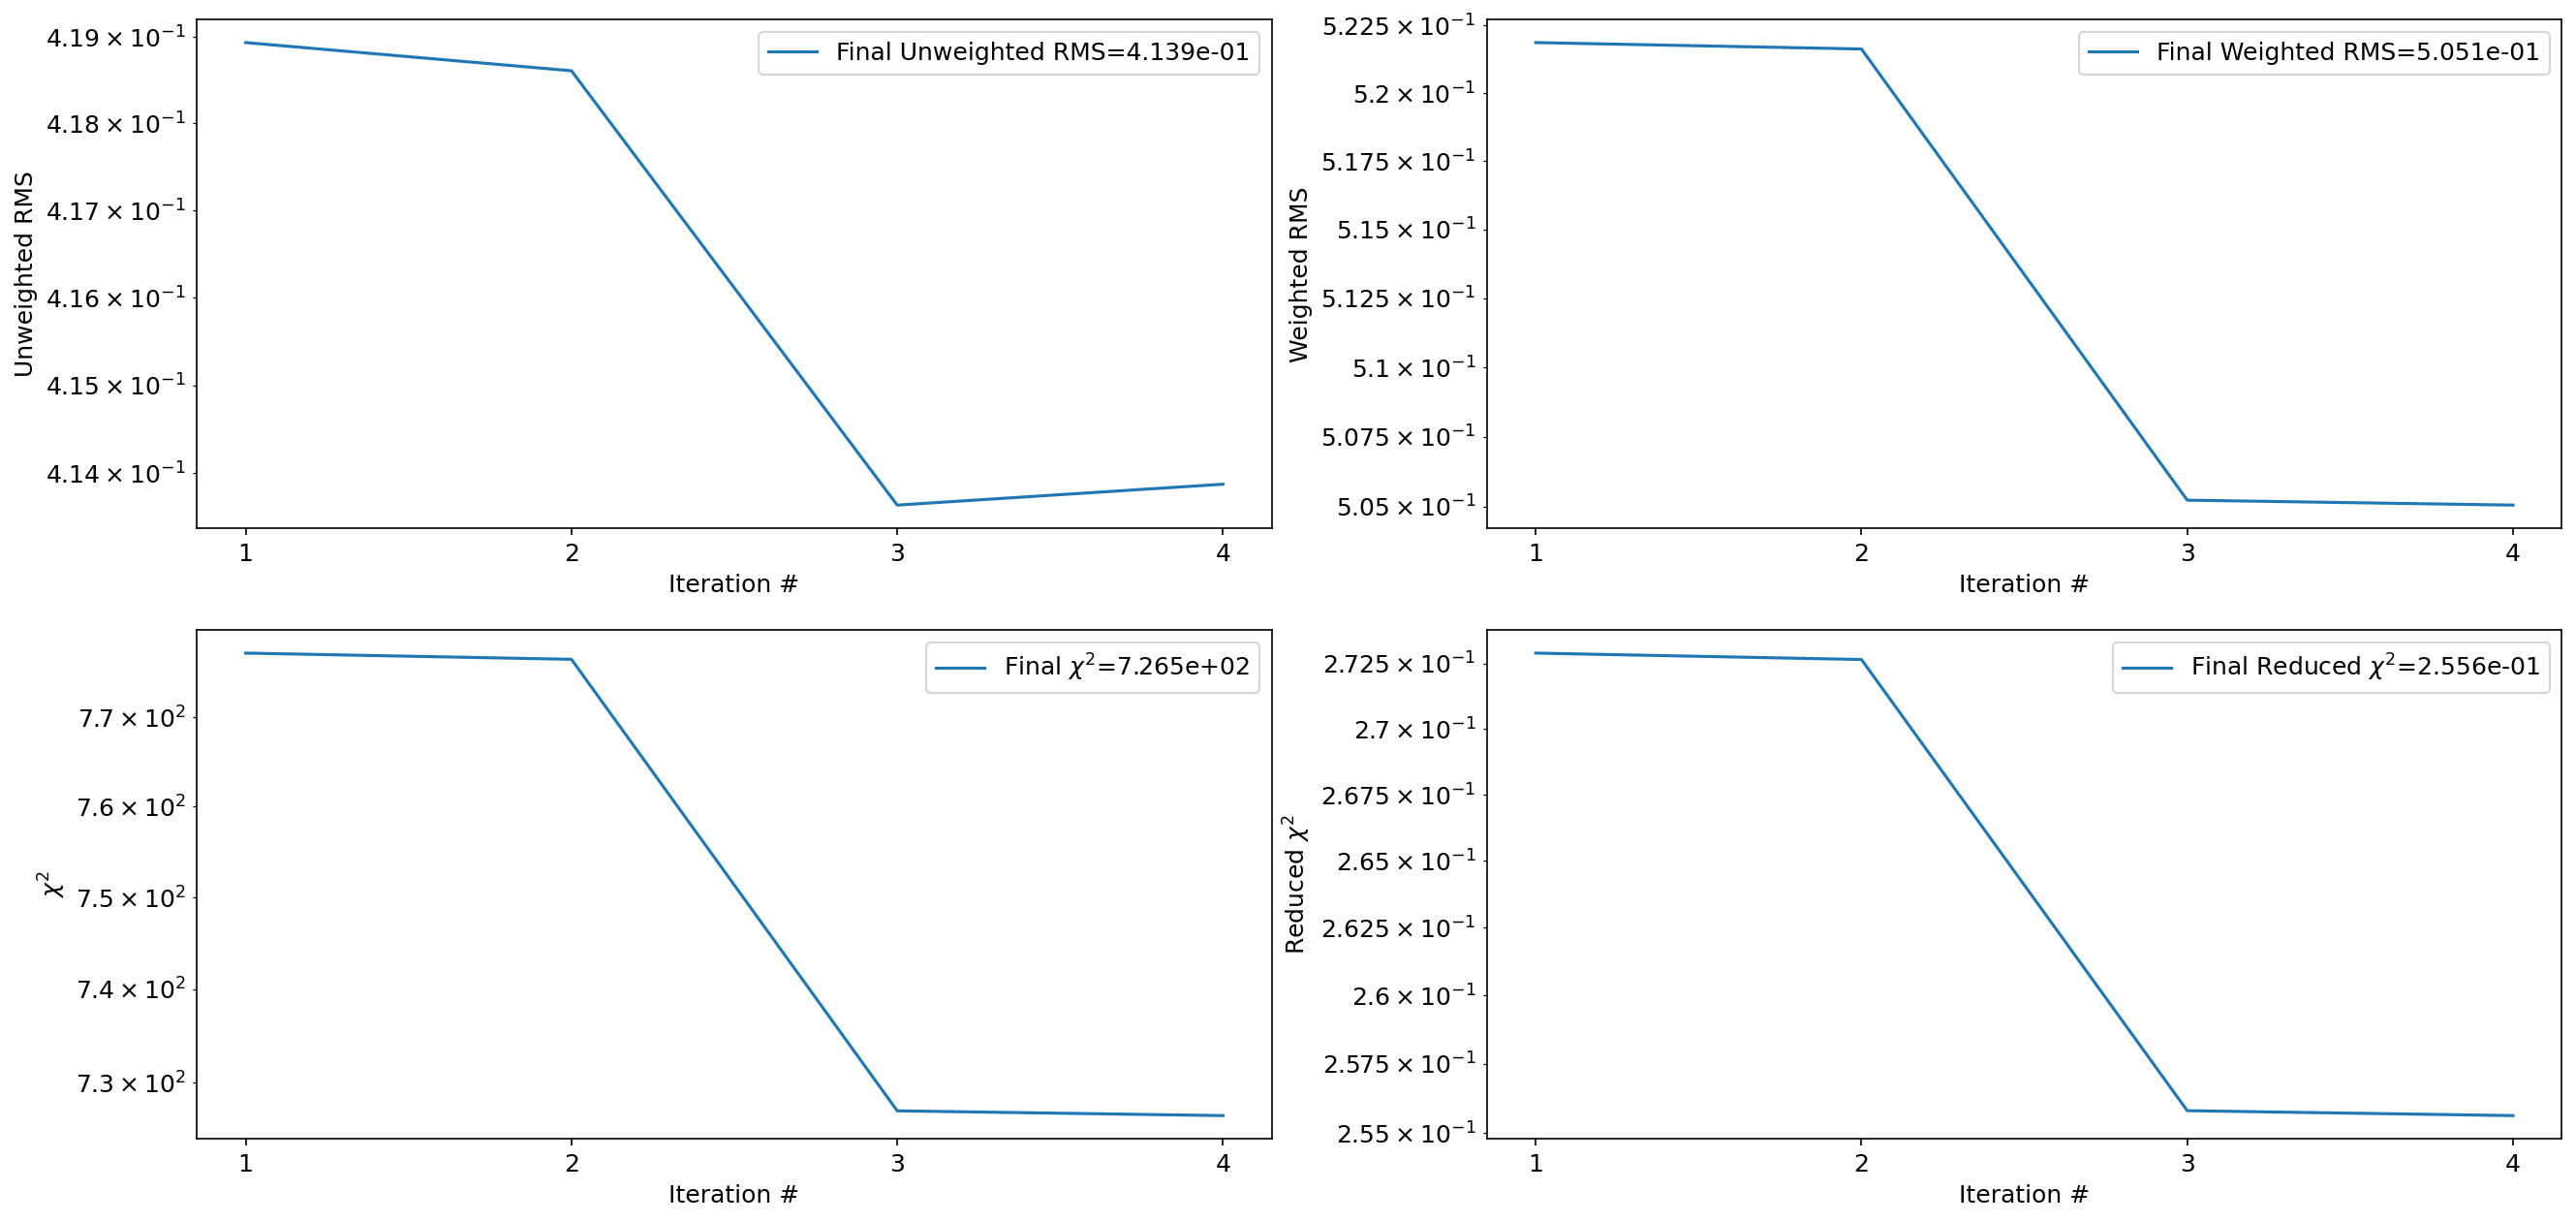

In [8]:
fit_sim.plot_summary(auto_close=True)

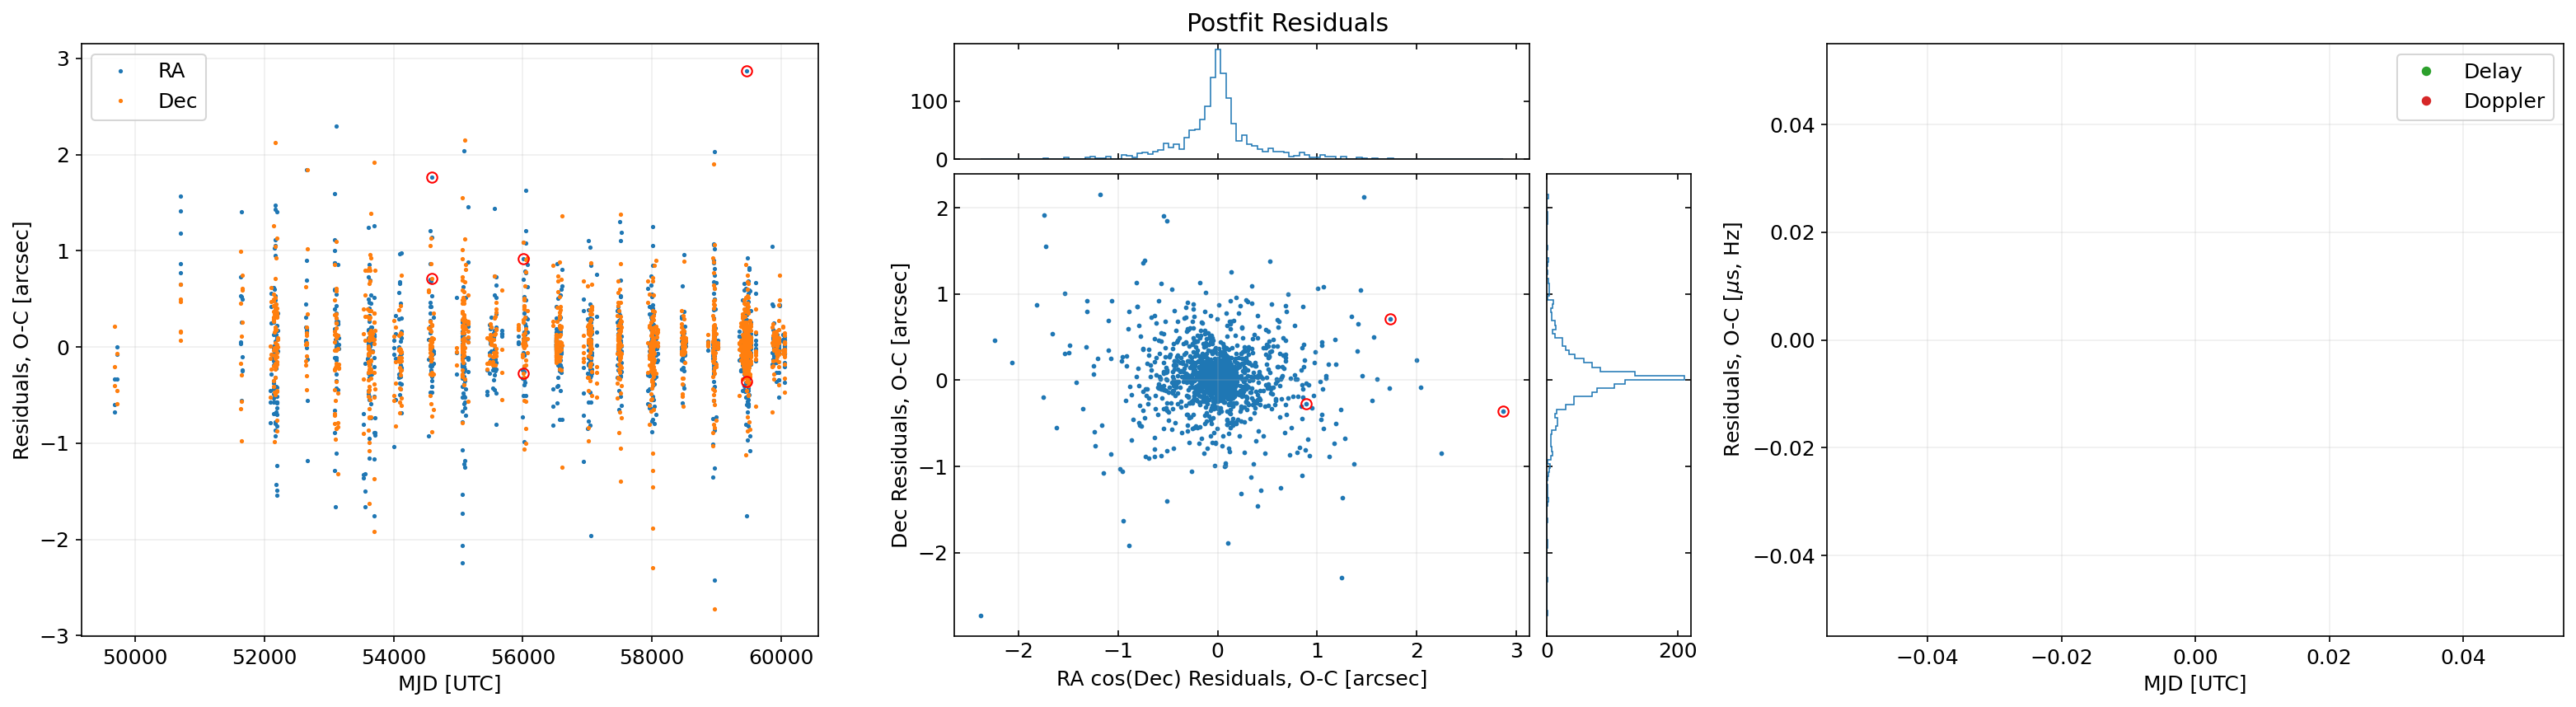

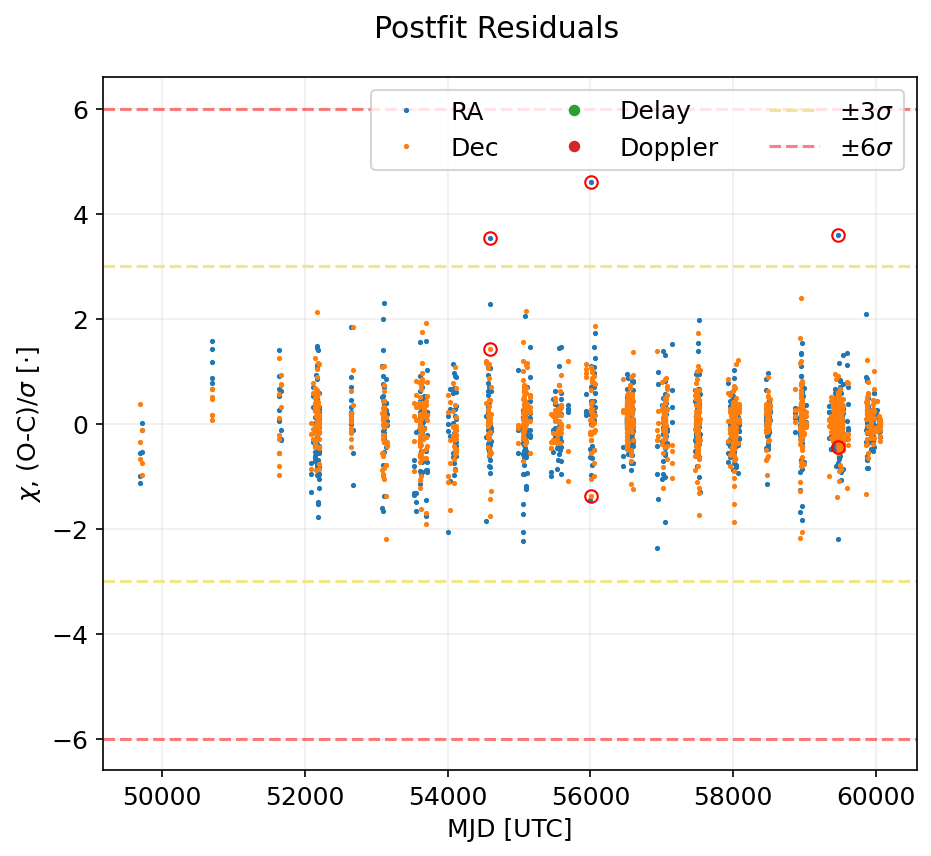

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.16
Mahalonobis distance between GRSS and JPL solution: 0.16
Bhattacharya distance between JPL and GRSS solution: 0.0015
Bhattacharya coefficient between JPL and GRSS solution: 0.9985


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90